In [6]:
src_path = '/kaggle/input/brain-t1-and-t1c-scans/T1 Cropped 3D-T/T1_imgs_middle_only/'
tar_path = '/kaggle/input/brain-t1-and-t1c-scans/T1c Cropped 3D-T/T1c_imgs_middle_only/'
img_size = (145, 184)

In [7]:
!pip install natsort

ERROR: Could not find a version that satisfies the requirement natsort (from versions: none)
ERROR: No matching distribution found for natsort


In [8]:
import re
from os import listdir
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# natural sort function بديلة عن natsort
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'([0-9]+)', s)]

# اقرأ كل الفايلات واعمل sort طبيعي
all_files = listdir(src_path)
all_files = sorted(all_files, key=natural_sort_key)

i = 0
src_list = []
for filename in all_files:
    img = load_img(src_path + filename, target_size=img_size)
    img = img_to_array(img)
    src_list.append(img)

    i += 1
    if i == 6000:
        break

6000


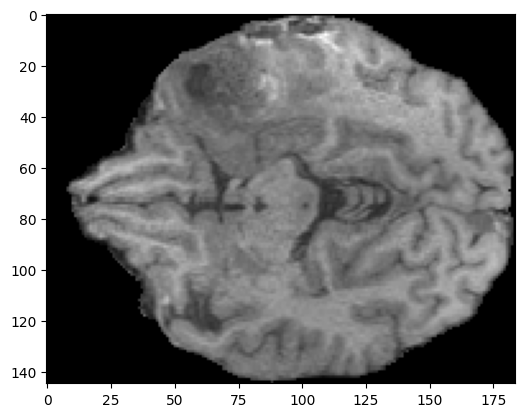

In [9]:
import matplotlib.pyplot as plt

print(len(src_list))
plt.imshow(src_list[5000].astype('int32'))

In [10]:
import re
from os import listdir
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# دالة تعمل sort طبيعي زي natsorted
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'([0-9]+)', s)]

# التعامل مع ملفات target
all_files = listdir(tar_path)
all_files = sorted(all_files, key=natural_sort_key)

tar_list = []
i = 0
for filename in all_files:
    img = load_img(tar_path + filename, target_size=img_size)
    img = img_to_array(img)
    tar_list.append(img)

    i += 1
    if i == 6000:
        break

6000


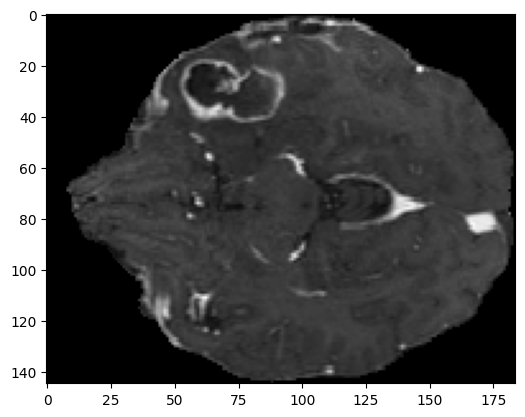

In [11]:
print(len(tar_list))
plt.imshow(tar_list[5000].astype('int32'))

In [12]:
import numpy as np
import tensorflow as tf
from keras import layers

In [13]:
def normalize(img):
    
    img = (img / 127.5) - 1
#     tar = (tar / 127.5) - 1
    
    return img

In [14]:
def resize(img):

    img = tf.image.resize(img, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     tar = tf.image.resize(tar, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return img

In [15]:
for i in range(len(src_list)):
    src_img = normalize(src_list[i])
    src_img = resize(src_img)

    src_list[i] = src_img

In [16]:
for i in range(len(tar_list)):
    tar_img = normalize(tar_list[i])
    tar_img = resize(tar_img)

    tar_list[i] = tar_img

In [17]:
src_list = np.array(src_list)
tar_list = np.array(tar_list)

In [18]:
with tf.device('/CPU:0'):
    src_list = tf.convert_to_tensor(src_list, dtype=tf.float32)
    tar_list = tf.convert_to_tensor(tar_list, dtype=tf.float32)

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((src_list, tar_list))

In [20]:
dataset = dataset.shuffle(buffer_size=len(dataset))

num_samples = len(dataset)

num_train = int(0.7 * num_samples)
num_val = int(0.15 * num_samples)
num_test = int(0.15 * num_samples)

train_dataset = dataset.take(num_train)
temp_dataset = dataset.skip(num_train)
val_dataset = temp_dataset.take(num_val)
test_dataset = temp_dataset.skip(num_val)

batch_size = 16
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [21]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

# SRGAN Models

In [22]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [23]:
def downsample(filters, size, batchnorm=True):
    
    init = tf.random_normal_initializer (0., 0.02)
    result = Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
    
    if batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())
    
    return result

# down_model = downsample(3, 4)
# down_result = down_model(tf.expand_dims(x[0], axis=0))
# print(down_result.shape)

In [24]:
def upsample(filters, size, dropout=False):
    
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
    result.add(layers.BatchNormalization())

    if dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.LeakyReLU())

    return result

# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print(up_result.shape)

In [25]:
def generator():
    down_stack = [
        downsample(64, 4, False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4,True),  # (bs, 2, 2, 1024)
        upsample(512, 4, True),  # (bs, 4, 4, 1024)
        upsample(512, 4,True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, 3)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

# Example usage:
gen = generator()
gen.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

In [26]:
gen = generator()
gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_15 (Sequential)     (None, 128, 128, 64  3072        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_16 (Sequential)     (None, 64, 64, 128)  131584      ['sequential_15[0][0]']          
                                                                                            

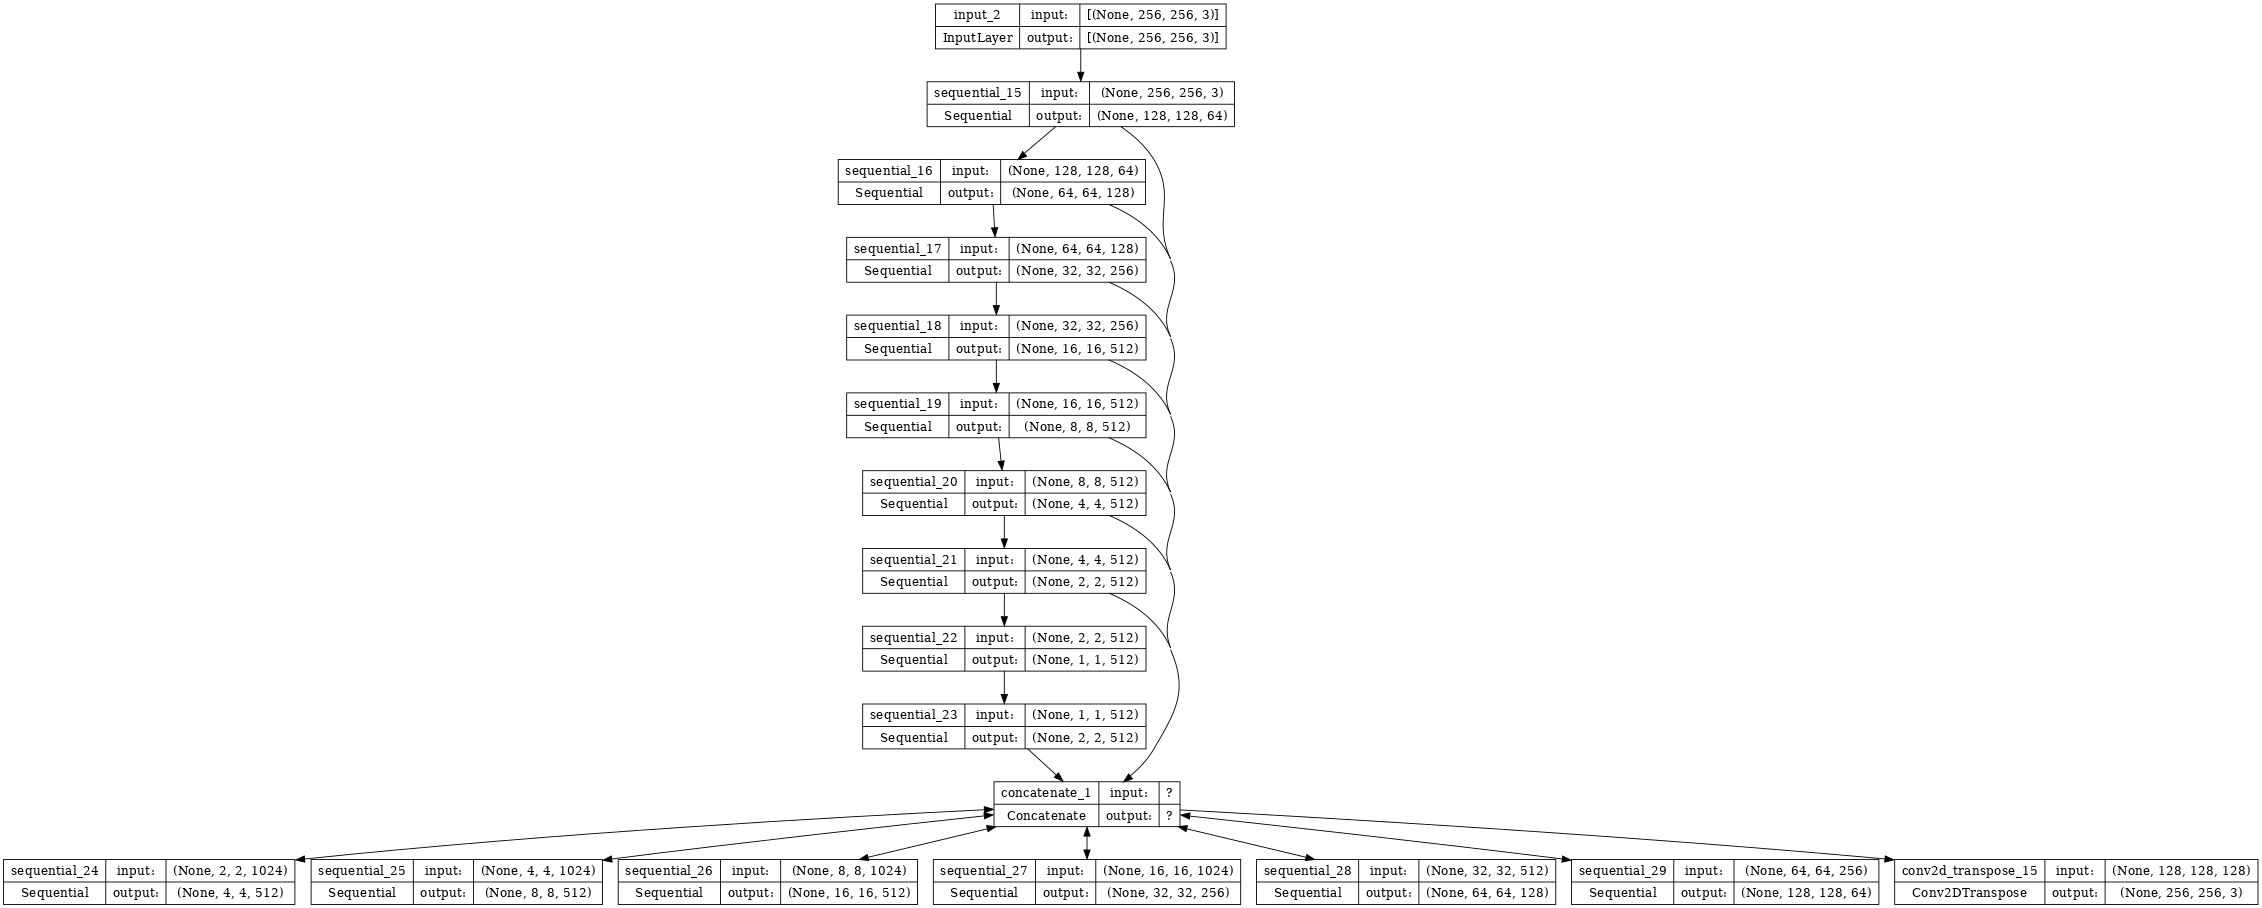

In [27]:
from keras.utils import plot_model

plot_model(gen, show_shapes=True, dpi=64)

In [28]:
LAMBDA = 100

In [29]:

def generator_loss(disc_generated_output, gen_output, target):
    mae = MeanAbsoluteError()
    
    gan_loss = mae(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = mae(target, gen_output)
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

In [30]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)

    input = layers.Input(shape=[256, 256, 3], name='input_image')
    target = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.Concatenate()([input, target])

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(zero_pad1)

    leaky_relu = layers.LeakyReLU()(conv)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=init)(zero_pad2)

    return keras.Model(inputs=[input, target], outputs=last)

# Example usage:
disc = discriminator()
disc.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

In [31]:
disc = discriminator()
disc.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

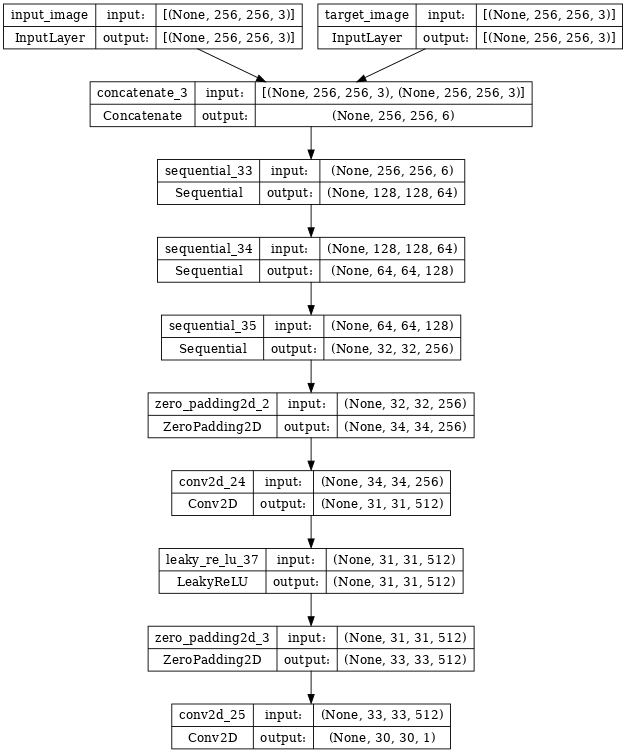

In [32]:
plot_model(disc, show_shapes=True, dpi=64)

In [33]:
from keras.losses import MeanAbsoluteError

def discriminator_loss(disc_real_output, disc_generated_output):
    mae = MeanAbsoluteError()
    
    real_loss = mae(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = mae(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [34]:
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adamax

generator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)

In [35]:
from skimage.metrics import structural_similarity

def save_images(model, test_input, target, epoch):

    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list=[test_input[0], target[0], prediction[0]]
    
    score, diff = structural_similarity(
        display_list[1].numpy(), display_list[2].numpy(),
        full=True, win_size=3, data_range=2
    )
    score = f'{score:.3f}'
    titles = ['Input Image', 'Ground Truth', 'Predicted Image: ' + str(score)]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.savefig(f'output/epoch_{epoch}.jpg')

In [36]:
epochs = 150

In [37]:
@tf.function
def train_step(input_image, target, epoch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Models output
        gen_output = gen(input_image, training = True)
        
        disc_real_output = disc([input_image, target], training = True)
        disc_generated_output = disc([input_image, gen_output], training = True)

        # Output losses
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        # Update Gradients with the losses
        generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)

        # Update Optimizers with gradients
        generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, disc_loss

In [38]:
import os

checkpoint_dir = '/kaggle/working/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator(),
    discriminator=discriminator(),
)

In [39]:
# epochs = 50
# import time
# for epoch in range(epochs):
#     start = time.time()

#     directory = 'output'
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     for input_, target in test_dataset.take(1):
#         save_images(gen, input_, target, epoch)

#     print(f"Epoch {epoch}")
#     for n, (input_, target) in train_dataset.enumerate():
#         gen_loss, disc_loss = train_step(input_, target, epoch)

#     gen_loss_value = tf.reduce_mean(gen_loss).numpy()
#     disc_loss_value = tf.reduce_mean(disc_loss).numpy()

#     gen_losses.append(gen_loss_value)
#     disc_losses.append(disc_loss_value)

#     if epoch % 5 == 0:
#         checkpoint.save(file_prefix=checkpoint_prefix)

#     print("Generator loss: {:.2f}".format(gen_loss_value))
#     print("Discriminator loss: {:.2f}".format(disc_loss_value))
#     print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))

# keras.backend.clear_session()


In [40]:
import time

def fit(train_ds, test_ds, epochs):

    for epoch in range(epochs):
        start = time.time()

        directory = 'output'
        if not os.path.exists(directory):
            os.makedirs(directory)

        for input_, target in test_ds.take(1):
            save_images(gen, input_, target, epoch)

        # Train
        print(f"Epoch {epoch}")
        for n, (input_, target) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_, target, epoch)

        gen_loss_value = tf.reduce_mean(gen_loss).numpy()
        disc_loss_value = tf.reduce_mean(disc_loss).numpy()

        gen_losses.append(gen_loss_value)
        disc_losses.append(disc_loss_value)

        if epoch % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Generator loss: {:.2f}".format(gen_loss_value))
        print("Discriminator loss: {:.2f}".format(disc_loss_value))
        print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))

In [41]:
# import time

# def fit(train_ds, test_ds, epochs):

#     for epoch in range(epochs):
#         start = time.time()

#         directory = 'output'
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#         for input_, target in test_ds.take(1):
#             save_images(gen, input_, target, epoch)

#         # Train
#         print(f"Epoch {epoch}")
#         for n, (input_, target) in train_ds.enumerate():
#             gen_loss, disc_loss = train_step(input_, target, epoch)

#         gen_loss_value = tf.reduce_mean(gen_loss).numpy()
#         disc_loss_value = tf.reduce_mean(disc_loss).numpy()

#         gen_losses.append(gen_loss_value)
#         disc_losses.append(disc_loss_value)

#         if epoch % 5 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

#         print("Generator loss: {:.2f}".format(gen_loss_value))
#         print("Discriminator loss: {:.2f}".format(disc_loss_value))
#         print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))
#         keras.backend.clear_session()
#         gen_losses  = list()
# disc_losses = list()


# fit(train_dataset, test_dataset, 20)

In [42]:
keras.backend.clear_session()

In [ ]:
gen_losses  = list()
disc_losses = list()


fit(train_dataset, test_dataset, 20)

Epoch 0


In [ ]:
ls {checkpoint_dir}

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
gen.save('generator52.h5')

In [ ]:
inputs, targets, predictions = list(), list(), list()

In [ ]:
for input_, tar in val_dataset.take(5):
    inputs.append(input_)
    targets.append(tar)
    predictions.append(gen(input_))


In [ ]:
from skimage.metrics import structural_similarity


for i in range(len(inputs)):
    plt.figure(figsize=(15, 15))
    display_list=[inputs[i][0], targets[i][0], predictions[i][0]]

    score, diff = structural_similarity(
        display_list[1].numpy(), display_list[2].numpy(),
        full=True, win_size=3, data_range=2
    )
    score = f'{score:.3f}'
    titles = ['Input Image', 'Ground Truth', 'Predicted Image: ' + str(score)]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

In [ ]:
import shutil

shutil.make_archive('/kaggle/working/pix2pix', 'zip', '/kaggle/working/', 'output')

In [ ]:
import matplotlib.pyplot as plt


plt.plot(gen_losses, label='gen_loss')
plt.plot(disc_losses, label='disc_loss')
plt.legend()
plt.show()

# Model 2

In [ ]:
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adamax

generator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5)

In [ ]:
from skimage.metrics import structural_similarity

def save_images(model, test_input, target, epoch):

    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list=[test_input[0], target[0], prediction[0]]
    
    score, diff = structural_similarity(
        display_list[1].numpy(), display_list[2].numpy(),
        full=True, win_size=3, data_range=2
    )
    score = f'{score:.3f}'
    titles = ['Input Image2', 'Ground Truth2', 'Predicted Image2: ' + str(score)]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.savefig(f'output/epoch_{epoch}.jpg')

In [ ]:
@tf.function
def train_step(input_image, target, epoch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Models output
        gen_output = gen(input_image, training = True)
        
        disc_real_output = disc([input_image, target], training = True)
        disc_generated_output = disc([input_image, gen_output], training = True)

        # Output losses
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        # Update Gradients with the losses
        generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)

        # Update Optimizers with gradients
        generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, disc_loss

In [ ]:
import os

checkpoint_dir = '/kaggle/working/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator(),
    discriminator=discriminator(),
)

In [ ]:
import time

def fit(train_ds, test_ds, epochs):

    for epoch in range(epochs):
        start = time.time()

        directory = 'output'
        if not os.path.exists(directory):
            os.makedirs(directory)

        for input_, target in test_ds.take(1):
            save_images(gen, input_, target, epoch)

        # Train
        print(f"Epoch {epoch}")
        for n, (input_, target) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_, target, epoch)

        gen_loss_value = tf.reduce_mean(gen_loss).numpy()
        disc_loss_value = tf.reduce_mean(disc_loss).numpy()

        gen_losses.append(gen_loss_value)
        disc_losses.append(disc_loss_value)

        if epoch % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Generator loss: {:.2f}".format(gen_loss_value))
        print("Discriminator loss: {:.2f}".format(disc_loss_value))
        print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))



In [ ]:
        keras.backend.clear_session()

In [ ]:
gen_losses  = list()
disc_losses = list()

fit(train_dataset, test_dataset, 100)

In [ ]:
import matplotlib.pyplot as plt


plt.plot(gen_losses, label='gen_loss')
plt.plot(disc_losses, label='disc_loss')
plt.legend()
plt.show()

In [ ]:

import shutil

shutil.make_archive('/kaggle/working/SRGANs ', 'zip', '/kaggle/working/', 'output')

In [ ]:
gen.save('generator52.h5')